In [313]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# EDA

## Clients Dataset

In [2]:
df_clients = pd.concat([pd.read_csv('data/client_train.csv')])

In [3]:
df_clients.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


Lets take a look at the columns names and types

In [4]:
df_clients.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')

I'm going to change the name of the disrict columt to district...

In [5]:
df_clients['district'] = df_clients['disrict']
del df_clients['disrict']

In [6]:
df_clients.dtypes

client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
district           int64
dtype: object

In [7]:
df_clients.describe()

,client_catg,region,target,district
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,11.512506,206.159809,0.055841,63.511222
std,4.423761,104.207044,0.229614,3.354400
min,11.000000,101.000000,0.000000,60.000000
25%,11.000000,103.000000,0.000000,62.000000
50%,11.000000,107.000000,0.000000,62.000000
75%,11.000000,307.000000,0.000000,69.000000
max,51.000000,399.000000,1.000000,69.000000


There are no missing values in the dataset.

In [8]:
df_clients.isna().sum()

client_id        0
client_catg      0
region           0
creation_date    0
target           0
district         0
dtype: int64

client_catg, region and district seem to be categorical columns.

In [9]:
for col in df_clients.columns:
    print("columnt:", col)
    print("unique values:", df_clients[col].unique())
    print("unique values count:", df_clients[col].nunique())
    print("**********")
    print()

columnt: client_id
unique values: ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999']
unique values count: 135493
**********

columnt: client_catg
unique values: [11 12 51]
unique values count: 3
**********

columnt: region
unique values: [101 107 301 105 303 103 309 311 304 104 312 305 306 308 372 307 313 310
 371 302 106 379 399 206 199]
unique values count: 25
**********

columnt: creation_date
unique values: ['31/12/1994' '29/05/2002' '13/03/1986' ... '16/08/2004' '30/08/1978'
 '25/05/1978']
unique values count: 8088
**********

columnt: target
unique values: [0. 1.]
unique values count: 2
**********

columnt: district
unique values: [60 69 62 63]
unique values count: 4
**********



There are no duplicated clients.

In [10]:
df_clients.client_id.duplicated().sum()

np.int64(0)

And decided to convert the creation_date field to an actual datetime. 

In [11]:
df_clients.creation_date = pd.to_datetime(df_clients.creation_date, dayfirst=True)

In [12]:
print("Most recent client in dataset:", df_clients.creation_date.max())

Most recent client in dataset: 2019-09-10 00:00:00


I'll format the client_id by lowercasing the contents.

And prefixed the district, region and client_catg columns to treat them as categorical clolumnts.

Also casted the target columnt as int.

In [13]:
df_clients['client_id'] = df_clients['client_id'].str.lower()
df_clients['district'] = 'district_' + df_clients['district'].astype('str')
df_clients['region'] = 'region_' + df_clients['region'].astype('str')
df_clients['client_catg'] = 'client_catg_' + df_clients['client_catg'].astype('str')
df_clients['target'] = df_clients['target'].astype(int)


Visualizing the target

<Axes: xlabel='target', ylabel='count'>

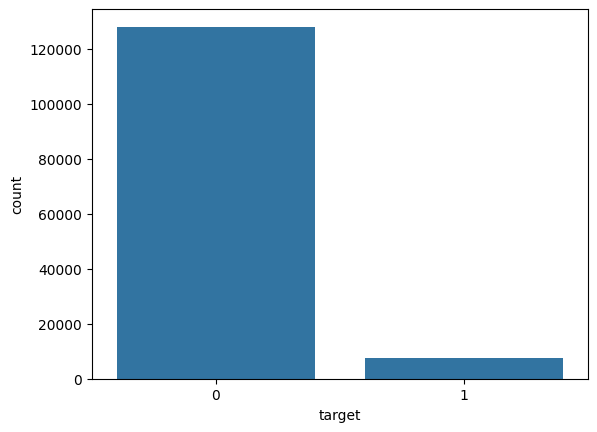

In [14]:
sns.countplot(x='target', data=df_clients)

In [15]:
df_clients['target'].value_counts(normalize=True)

target
0    0.944159
1    0.055841
Name: proportion, dtype: float64

In [16]:
global_fraud_rate = df_clients.target.mean()
print("Global Fraud Rate:", round(global_fraud_rate, 2)) # 6% of clients commit fraud

Global Fraud Rate: 0.06


From the results above we can see we are working with an imbalaced target variable.

<Axes: xlabel='district', ylabel='count'>

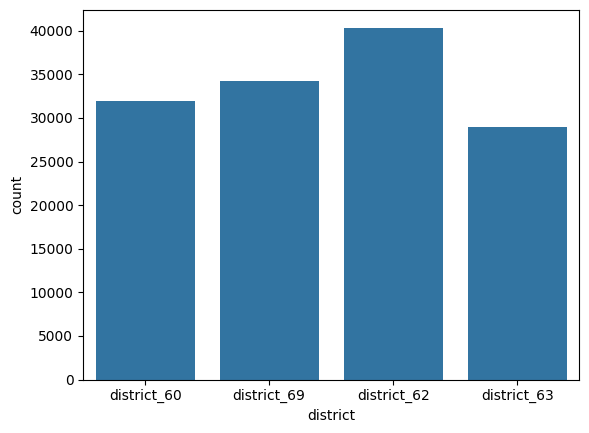

In [17]:
sns.countplot(x='district', data=df_clients)


In [18]:
def print_rate_and_risk(data, by):
    fraud = data.groupby(by).target.agg(['mean', 'count'])
    fraud['diff'] = fraud['mean'] - global_fraud_rate
    fraud['risk'] = fraud['mean'] / global_fraud_rate
    print(fraud)


print_rate_and_risk(df_clients, 'district')



                 mean  count      diff      risk
district                                        
district_60  0.035869  31922 -0.019972  0.642341
district_62  0.051619  40353 -0.004221  0.924409
district_63  0.065236  28987  0.009396  1.168258
district_69  0.071485  34231  0.015644  1.280162


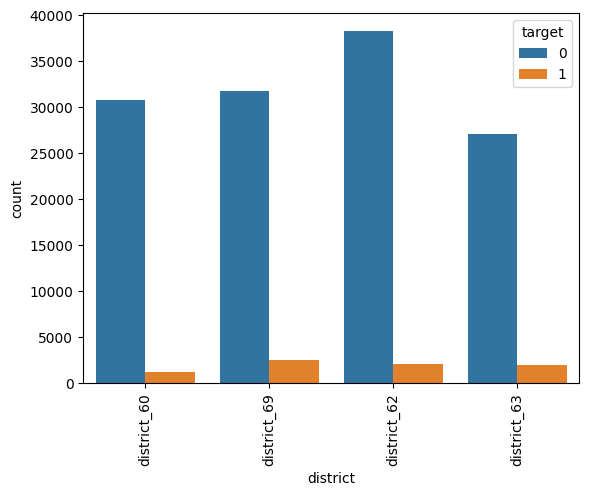

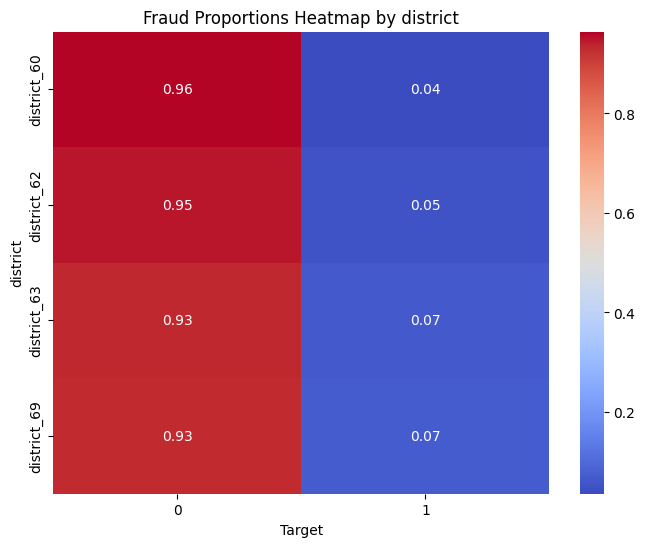

In [19]:
def fraud_proportions(data, by):
    sns.countplot(x=by, hue='target', data=data).tick_params(axis='x', rotation=90)
    
    cross_tabulation = pd.crosstab(data[by], data.target, normalize='index')
    # ct_district.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cross_tabulation, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.title(f'Fraud Proportions Heatmap by {by}')
    plt.xlabel('Target')
    plt.ylabel(by)
    plt.show()


fraud_proportions(df_clients, 'district')

In [20]:
mutual_info_score(df_clients.target, df_clients.district)

np.float64(0.0017772598794705413)

There are some districts that seem to have more risk of fraud like district_69 and district_63. But the mutual_info_score is low.

<Axes: xlabel='client_catg', ylabel='count'>

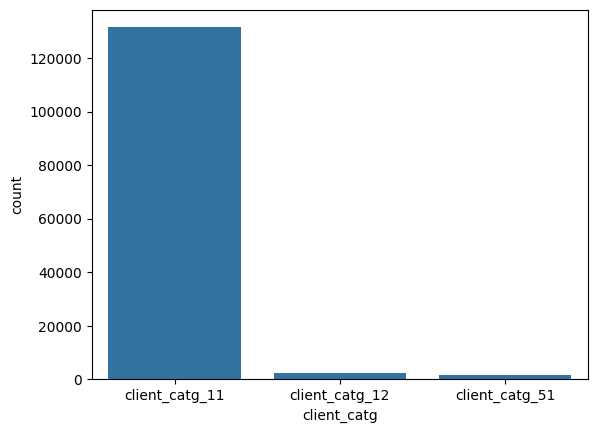

In [21]:
sns.countplot(x='client_catg', data=df_clients)

In [22]:
print_rate_and_risk(df_clients, 'client_catg')

                    mean   count      diff      risk
client_catg                                         
client_catg_11  0.054687  131494 -0.001154  0.979341
client_catg_12  0.039638    2321 -0.016202  0.709844
client_catg_51  0.168653    1678  0.112813  3.020265


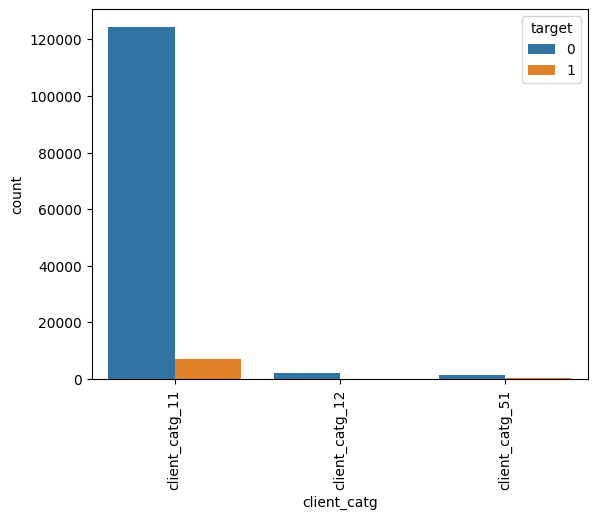

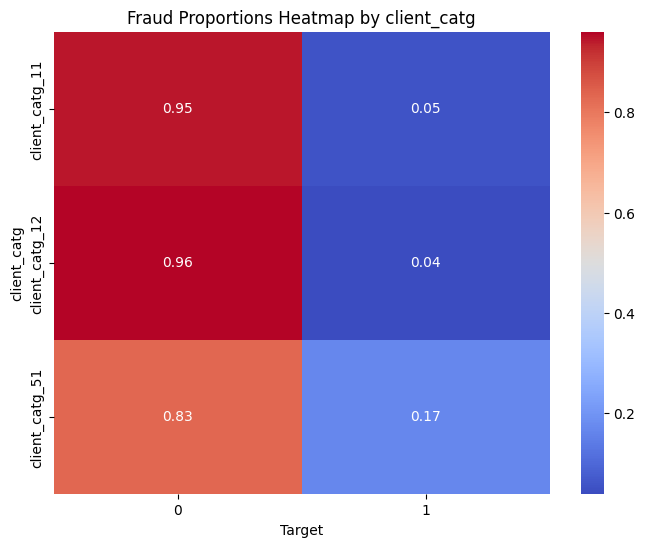

In [23]:
fraud_proportions(df_clients, 'client_catg')

In [24]:
mutual_info_score(df_clients.target, df_clients.client_catg)

np.float64(0.0010581315760997117)

The client_catg is also very imbalanced and with a low mutual_info_score.

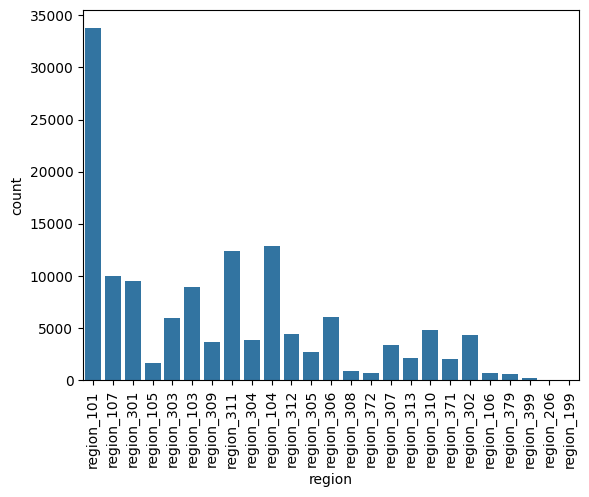

In [25]:
sns.countplot(x='region', data=df_clients).tick_params(axis='x', rotation=90)

In [26]:
print_rate_and_risk(df_clients, "region")

                mean  count      diff      risk
region                                         
region_101  0.035919  33770 -0.019921  0.643251
region_103  0.102967   8964  0.047127  1.843955
region_104  0.055966  12865  0.000125  1.002243
region_105  0.055927   1645  0.000087  1.001550
region_106  0.075071    706  0.019230  1.344379
region_107  0.065813   9998  0.009973  1.178591
region_199  0.000000      2 -0.055841  0.000000
region_206  0.018868     53 -0.036973  0.337889
region_301  0.033005   9544 -0.022835  0.591059
region_302  0.061703   4311  0.005862  1.104979
region_303  0.054497   5982 -0.001344  0.975937
region_304  0.066876   3828  0.011035  1.197619
region_305  0.057806   2716  0.001965  1.035191
region_306  0.048643   6044 -0.007197  0.871111
region_307  0.062204   3376  0.006363  1.113954
region_308  0.072533    841  0.016692  1.298926
region_309  0.043064   3669 -0.012777  0.771187
region_310  0.050917   4851 -0.004923  0.911835
region_311  0.080445  12406  0.024604  1

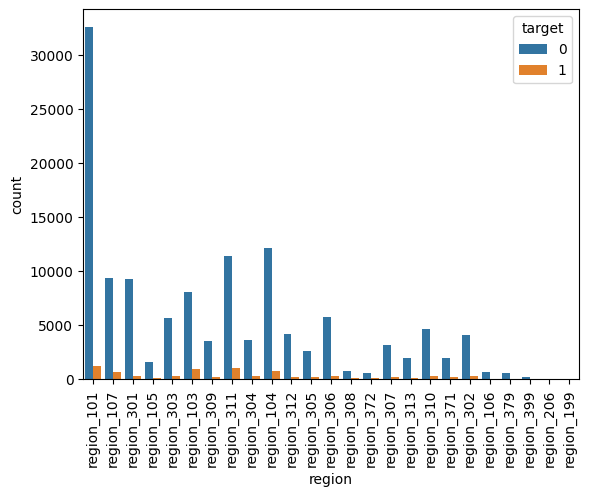

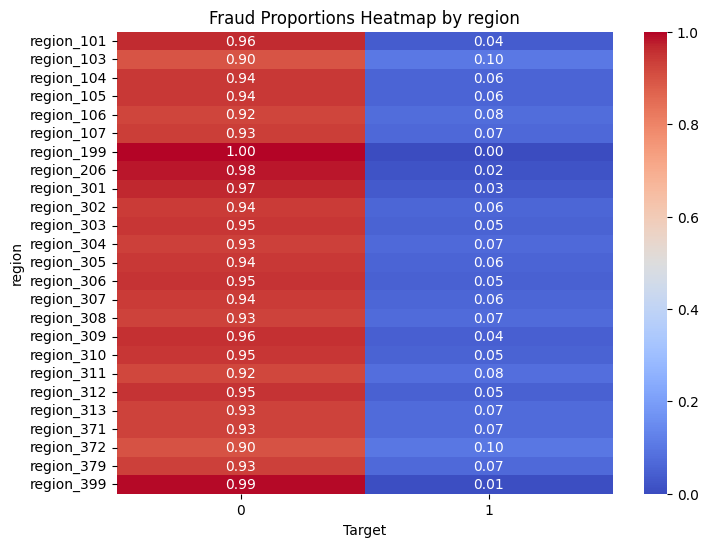

In [27]:
fraud_proportions(df_clients, 'region')

Taking a close look at region_105, region_199, region_206, region_308, region_372, region_379 and region_399.

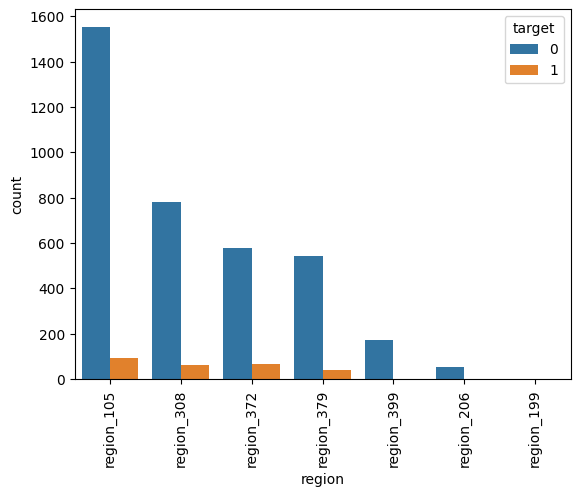

In [28]:
sns.countplot(x='region', hue='target', data=df_clients[df_clients.region.isin(['region_105', 'region_199', 'region_206', 'region_308', 'region_372', 'region_379', 'region_399'])]).tick_params(axis='x', rotation=90)

Only two clients in region_199

In [29]:
len(df_clients[df_clients.region == 'region_199'])

2

In [30]:
mutual_info_score(df_clients.target, df_clients.region)

np.float64(0.003505769470051335)

There are some regions that seem to have more risk of fraud like region_103 and region_372 among others. The mutual_info_score is low but larger than district.

This are going to be my 3 categorical columns.

In [141]:
category_cols = ['client_catg', 'region', 'district']

## Invoices Dataset

In [31]:
df_invoices = pd.concat([pd.read_csv('data/invoice_train.csv')])

/var/folders/km/dql4gckx6ps4lrl0mdrhnsbh0000gn/T/ipykernel_2856/449422951.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_invoices = pd.concat([pd.read_csv('data/invoice_train.csv')])


There is a warning indicating tha Column # 4 have mixed types. I'll check that in a moment.

In [32]:
df_invoices.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


I lowercased the contents of columns client_id and counter_type.

Also changed the names of counter_statue to counter_status. And changed the names of all the consommation_level_* columns to consumption_level_*.

In [34]:
df_invoices['client_id'] = df_invoices['client_id'].str.lower()
df_invoices['counter_type'] = df_invoices['counter_type'].str.lower()
df_invoices['counter_status'] = df_invoices['counter_statue']
df_invoices['consumption_level_1'] = df_invoices['consommation_level_1']
df_invoices['consumption_level_2'] = df_invoices['consommation_level_2']
df_invoices['consumption_level_3'] = df_invoices['consommation_level_3']
df_invoices['consumption_level_4'] = df_invoices['consommation_level_4']

del df_invoices['counter_statue']
del df_invoices['consommation_level_1']
del df_invoices['consommation_level_2']
del df_invoices['consommation_level_3']
del df_invoices['consommation_level_4']

Taking a look at some of the data and the types of the columns and the result of the describe method.

In [35]:
df_invoices.head()

,client_id,invoice_date,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,counter_type,counter_status,consumption_level_1,consumption_level_2,consumption_level_3,consumption_level_4
0,train_client_0,2014-03-24,11,1335667,203,8,1,14302,14384,4,elec,0,82,0,0,0
1,train_client_0,2013-03-29,11,1335667,203,6,1,12294,13678,4,elec,0,1200,184,0,0
2,train_client_0,2015-03-23,11,1335667,203,8,1,14624,14747,4,elec,0,123,0,0,0
3,train_client_0,2015-07-13,11,1335667,207,8,1,14747,14849,4,elec,0,102,0,0,0
4,train_client_0,2016-11-17,11,1335667,207,9,1,15066,15638,12,elec,0,572,0,0,0


In [36]:
df_invoices.dtypes

client_id              object
invoice_date           object
tarif_type              int64
counter_number          int64
counter_code            int64
reading_remarque        int64
counter_coefficient     int64
old_index               int64
new_index               int64
months_number           int64
counter_type           object
counter_status         object
consumption_level_1     int64
consumption_level_2     int64
consumption_level_3     int64
consumption_level_4     int64
dtype: object

In [37]:
df_invoices.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,consumption_level_1,consumption_level_2,consumption_level_3,consumption_level_4
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,1.776700e+04,1.834970e+04,4.483095e+01,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,4.036693e+04,4.095321e+04,3.128335e+03,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,2.800280e+06,2.870972e+06,6.366240e+05,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05


Looking for null values i couldn't find any but I need to remember that counter_status contains mixed types.

In [38]:
df_invoices.isna().sum()

client_id              0
invoice_date           0
tarif_type             0
counter_number         0
counter_code           0
reading_remarque       0
counter_coefficient    0
old_index              0
new_index              0
months_number          0
counter_type           0
counter_status         0
consumption_level_1    0
consumption_level_2    0
consumption_level_3    0
consumption_level_4    0
dtype: int64

In [39]:
for col in df_invoices.columns:
    print("column:", col)
    print("unique values:", df_invoices[col].unique())
    print("unique values count:", df_invoices[col].nunique())
    print("**********")
    print()

column: client_id
unique values: ['train_client_0' 'train_client_1' 'train_client_10' ...
 'train_client_99997' 'train_client_99998' 'train_client_99999']
unique values count: 135493
**********

column: invoice_date
unique values: ['2014-03-24' '2013-03-29' '2015-03-23' ... '1995-11-28' '1982-07-04'
 '1996-09-02']
unique values count: 8275
**********

column: tarif_type
unique values: [11 40 15 10 12 14 13 45 29  9 30  8 21 42 27 18 24]
unique values count: 17
**********

column: counter_number
unique values: [1335667  678902  572765 ... 4811719  262195  560948]
unique values count: 201893
**********

column: counter_code
unique values: [203 207 413   5 467 202 420 410  10 483  25 433 407 204 214 442 453 506
 450 403 333 201 102 305 210 101 532  40 310 565 600 307 303 222  65   0
 227 325  16 317 367   1]
unique values count: 42
**********

column: reading_remarque
unique values: [  8   6   9   7 207 413 203   5]
unique values count: 8
**********

column: counter_coefficient
unique val

I'll take a look at counter_status.

<Axes: xlabel='counter_status', ylabel='count'>

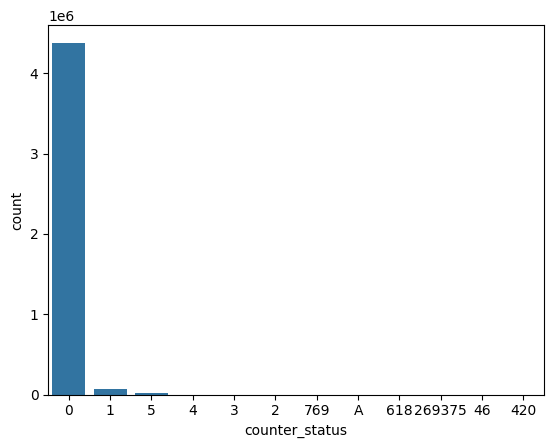

In [40]:
# df_invoice.counter_statue.value_counts().plot(kind='bar')
sns.countplot(x='counter_status', data=df_invoices)

In [41]:
len(df_invoices[df_invoices.counter_status == 'A'])

13

In [42]:
df_invoices.counter_status = pd.to_numeric(df_invoices.counter_status, errors='coerce').fillna(999999).astype(int)

In [43]:
len(df_invoices[df_invoices.counter_status > 5])

47

I decided to remove all the counter_status greater than 5 because it seems all the other values are just too random to be a status.

In [44]:
df_invoices = df_invoices[df_invoices.counter_status <= 5]

And prefixed a counter_status string maybe I can use it as a categorical value too... we'll see.

In [45]:
df_invoices['counter_status'] = 'counter_status_' + df_invoices['counter_status'].astype(str)

The dates can be casted to datetime so thats ok.

In [46]:
df_invoices.invoice_date = pd.to_datetime(df_invoices.invoice_date, yearfirst=True)

The most rescent invoice is from 2019-12-07

In [47]:
print("Most recent invoice:", df_invoices.invoice_date.max())

Most recent invoice: 2019-12-07 00:00:00


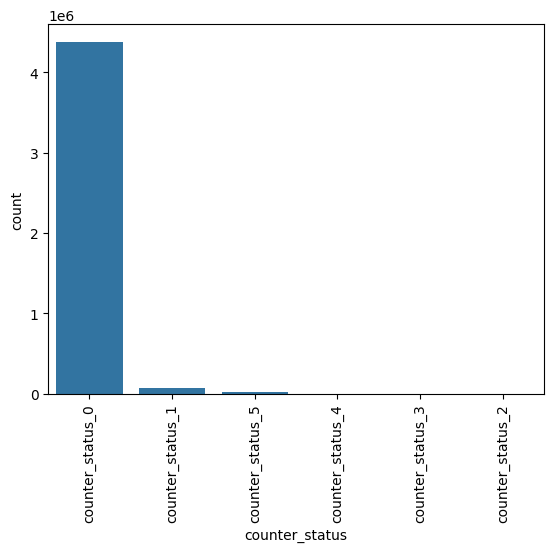

In [48]:
sns.countplot(x='counter_status', data=df_invoices).tick_params(axis='x', rotation=90)

<Axes: xlabel='counter_status', ylabel='count'>

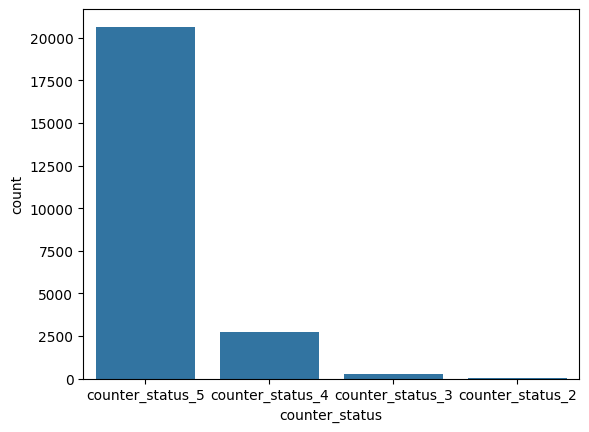

In [49]:
sns.countplot(x='counter_status', data=df_invoices[df_invoices.counter_status > 'counter_status_1'])

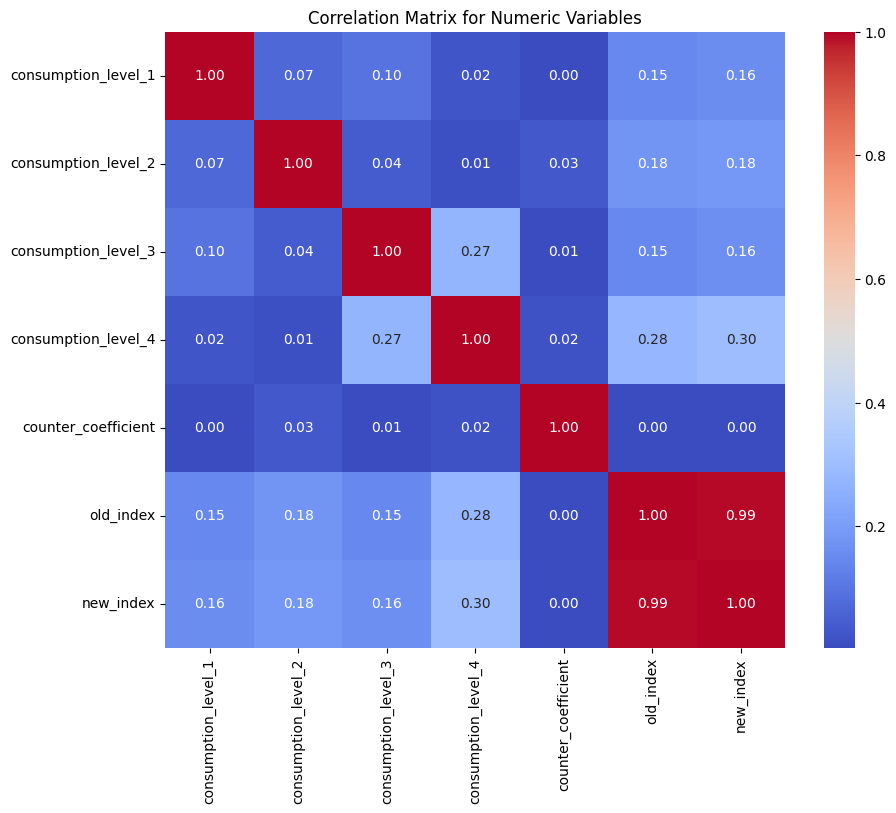

In [50]:
numeric_cols = ['consumption_level_1', 'consumption_level_2', 'consumption_level_3', 'consumption_level_4', 'counter_coefficient', 'old_index', 'new_index']

correlation_matrix = df_invoices[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Numeric Variables')
plt.show()

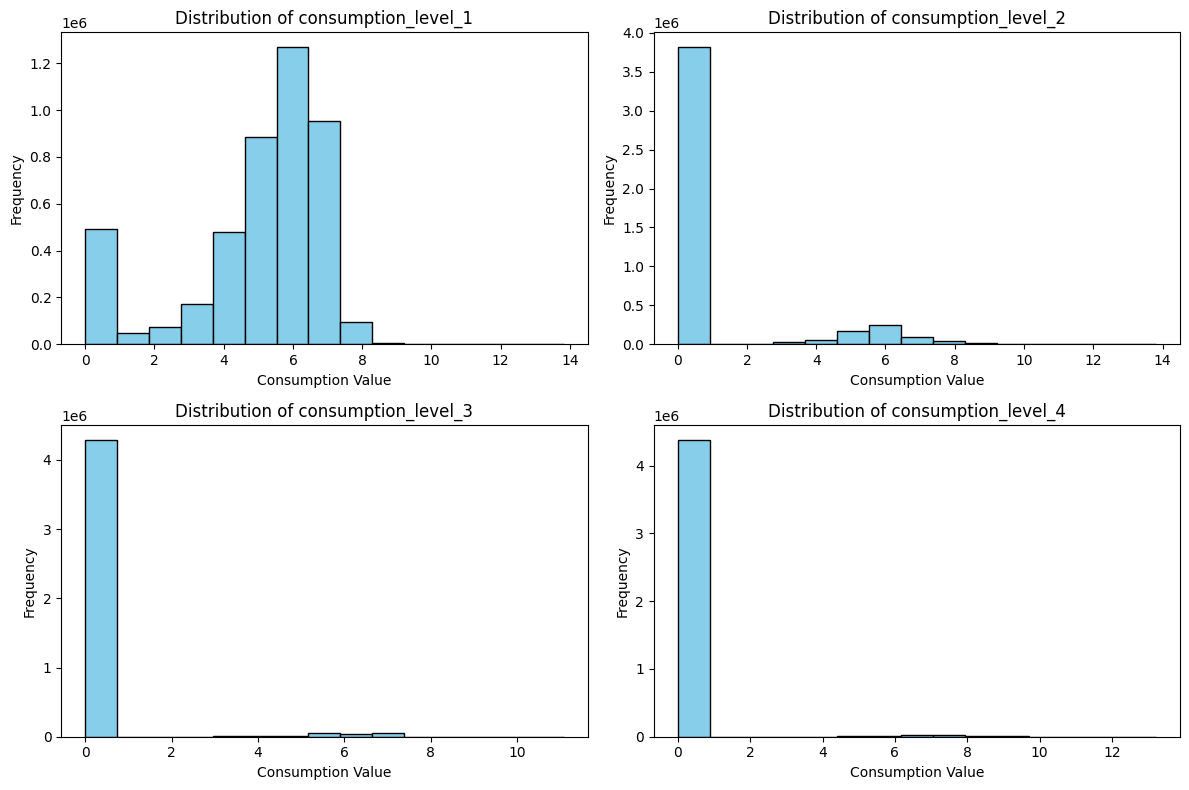

In [51]:
# Columns to analyze
consumption_cols = ['consumption_level_1', 'consumption_level_2', 'consumption_level_3', 'consumption_level_4']

plt.figure(figsize=(12, 8))
for i, col in enumerate(consumption_cols, 1):
    print()
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    plt.hist(np.log1p(df_invoices[col]), bins=15, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Consumption Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [52]:
for col in consumption_cols:
    print(col)
    print(df_invoices[col].describe().apply("{0:.3f}".format))
    print("**********")
    print()

consumption_level_1
count    4476702.000
mean         410.984
std          757.311
min            0.000
25%           79.000
50%          274.000
75%          600.000
max       999910.000
Name: consumption_level_1, dtype: object
**********

consumption_level_2
count    4476702.000
mean         109.319
std         1220.128
min            0.000
25%            0.000
50%            0.000
75%            0.000
max       999073.000
Name: consumption_level_2, dtype: object
**********

consumption_level_3
count    4476702.000
mean          20.306
std          157.425
min            0.000
25%            0.000
50%            0.000
75%            0.000
max        64492.000
Name: consumption_level_3, dtype: object
**********

consumption_level_4
count    4476702.000
mean          52.926
std          875.477
min            0.000
25%            0.000
50%            0.000
75%            0.000
max       547946.000
Name: consumption_level_4, dtype: object
**********



There are two clients in the clients dataset that don't have corresponding invoice data.

In [53]:
df_clients_with_invoice = df_clients[df_clients.client_id.isin(df_invoices.client_id.drop_duplicates())]
print("Clients with invoice data:", len(df_clients_with_invoice))

df_clients_without_invoice = df_clients[~df_clients.client_id.isin(df_invoices.client_id.drop_duplicates())]
print("Clients without invoice data:", len(df_clients_without_invoice))

Clients with invoice data: 135491
Clients without invoice data: 2


In [54]:
df_clients_without_invoice

,client_id,client_catg,region,creation_date,target,district
77473,train_client_47780,client_catg_11,region_306,2015-05-08,0,district_63
84079,train_client_53725,client_catg_11,region_101,1982-11-15,0,district_60


Extended the invoices dataset, added target to check if I can find something else.

In [55]:
df_invoices_extended = df_invoices.copy()
df_invoices_extended = df_invoices_extended.merge(df_clients[['client_id', 'target']], on='client_id', how='left')


In [56]:
# tarif_type, counter_code, reading_remarque, counter_coefficient, counter_type, counter_status
print_rate_and_risk(df_invoices_extended, 'tarif_type')

                mean    count      diff       risk
tarif_type                                        
8           0.023256       43 -0.032585   0.416468
9           0.073522     6039  0.017682   1.316644
10          0.089081   276210  0.033240   1.595271
11          0.073656  2679839  0.017815   1.319034
12          0.111415    11345  0.055574   1.995231
13          0.111616    11656  0.055776   1.998841
14          0.112135    11611  0.056295   2.008130
15          0.123369    72409  0.067528   2.209303
18          1.000000        4  0.944159  17.908142
21          0.105769      104  0.049929   1.894130
24          0.000000        9 -0.055841   0.000000
27          0.000000        1 -0.055841   0.000000
29          0.108821    10090  0.052980   1.948775
30          0.000000       35 -0.055841   0.000000
40          0.082205  1379754  0.026364   1.472130
42          0.000000        1 -0.055841   0.000000
45          0.190406    17552  0.134565   3.409811


In [57]:
mutual_info_score(df_invoices_extended.target, df_invoices_extended.tarif_type)

np.float64(0.0006868870754701628)

In [338]:
def print_with_multiple(feature):
    unique_counts = df_invoices_extended.groupby('client_id')[feature].nunique()
    clients_with_multiple = unique_counts[unique_counts > 1].index
    print(clients_with_multiple)
    filtered = df_invoices_extended[df_invoices_extended.client_id.isin(clients_with_multiple)]
    print("Mutual info score:", mutual_info_score(filtered.target, filtered[feature]))
    
print_with_multiple('tarif_type')

Index(['train_client_10000', 'train_client_100000', 'train_client_100001',
       'train_client_100004', 'train_client_100005', 'train_client_100006',
       'train_client_10001', 'train_client_100010', 'train_client_100011',
       'train_client_100013',
       ...
       'train_client_99987', 'train_client_99988', 'train_client_99989',
       'train_client_9999', 'train_client_99991', 'train_client_99992',
       'train_client_99993', 'train_client_99995', 'train_client_99996',
       'train_client_99997'],
      dtype='object', name='client_id', length=64654)
Mutual info score: 0.0008768720572951286


There are some tarifs with greater risk but with even smaller mutual_info_score... and tried to check if a client changed tarif that increases the multual_info_score by a little bit... but again I can't find a lot of correlation.

In [59]:
print_rate_and_risk(df_invoices_extended, 'counter_code')

                  mean    count      diff      risk
counter_code                                       
5             0.081231  1352035  0.025390  1.454694
10            0.129578    27744  0.073737  2.320493
16            0.027397       73 -0.028443  0.490634
25            0.177380    14934  0.121540  3.176555
40            0.278405     2482  0.222564  4.985707
65            0.000000       74 -0.055841  0.000000
101           0.000000       74 -0.055841  0.000000
102           0.000000      313 -0.055841  0.000000
201           0.072341     7672  0.016500  1.295493
202           0.096519   343238  0.040679  1.728477
203           0.074940  1516836  0.019100  1.342040
204           0.122556    12427  0.066715  2.194745
207           0.057848   555628  0.002008  1.035951
210           0.115336      789  0.059495  2.065451
214           0.127507     2643  0.071666  2.283407
222           0.000000       42 -0.055841  0.000000
227           0.056180      178  0.000339  1.006075
303         

In [60]:
mutual_info_score(df_invoices_extended.target, df_invoices_extended.counter_code)

np.float64(0.0013855210319302037)

In [339]:
print_with_multiple('counter_code')

Index(['train_client_0', 'train_client_10', 'train_client_10000',
       'train_client_100000', 'train_client_100001', 'train_client_100004',
       'train_client_100005', 'train_client_100006', 'train_client_10001',
       'train_client_100010',
       ...
       'train_client_99987', 'train_client_99988', 'train_client_99989',
       'train_client_9999', 'train_client_99991', 'train_client_99992',
       'train_client_99993', 'train_client_99995', 'train_client_99996',
       'train_client_99997'],
      dtype='object', name='client_id', length=66136)
Mutual info score: 0.0019440777764332252


There is a little bit more correlation between counter_code and target. And I'm not sure how to add this clients that have more than one value on this columns. 

In [62]:
# reading_remarque, counter_coefficient, counter_type, counter_status
print_rate_and_risk(df_invoices_extended, 'reading_remarque')

                      mean    count      diff      risk
reading_remarque                                       
6                 0.077070  2230926  0.021230  1.380185
7                 0.001513      661 -0.054328  0.027092
8                 0.081834   828123  0.025994  1.465503
9                 0.080032  1416992  0.024191  1.433216


In [63]:
mutual_info_score(df_invoices_extended.target, df_invoices_extended.reading_remarque)

np.float64(3.618117724731875e-05)

In [340]:
print_with_multiple('reading_remarque')

Index(['train_client_0', 'train_client_1', 'train_client_10',
       'train_client_100', 'train_client_1000', 'train_client_10000',
       'train_client_100000', 'train_client_100001', 'train_client_100002',
       'train_client_100004',
       ...
       'train_client_99988', 'train_client_99989', 'train_client_9999',
       'train_client_99990', 'train_client_99991', 'train_client_99992',
       'train_client_99993', 'train_client_99994', 'train_client_99996',
       'train_client_99998'],
      dtype='object', name='client_id', length=110779)
Mutual info score: 4.9334628288007394e-05


There is almost no dependence between reading_remarque and target. This columns also contains client that have different values on reading_remarque and I'm not sure how to add this.

In [64]:
print_rate_and_risk(df_invoices_extended, 'counter_coefficient')

                         mean    count      diff       risk
counter_coefficient                                        
0                    0.021739       46 -0.034101   0.389307
1                    0.078905  4475089  0.023065   1.413050
2                    0.000000      886 -0.055841   0.000000
3                    0.000000      321 -0.055841   0.000000
4                    0.000000       12 -0.055841   0.000000
5                    1.000000        1  0.944159  17.908142
10                   0.166667        6  0.110826   2.984690
11                   0.000000        1 -0.055841   0.000000
20                   0.000000        3 -0.055841   0.000000
30                   0.000000      137 -0.055841   0.000000
33                   0.000000        1 -0.055841   0.000000
40                   0.000000      197 -0.055841   0.000000
50                   0.000000        2 -0.055841   0.000000


In [65]:
mutual_info_score(df_invoices_extended.target, df_invoices_extended.counter_coefficient)

np.float64(2.9576196850328653e-05)

In [341]:
print_with_multiple('counter_coefficient')

Index(['train_client_104833', 'train_client_108022', 'train_client_111792',
       'train_client_115236', 'train_client_11774', 'train_client_118876',
       'train_client_121179', 'train_client_127047', 'train_client_129382',
       'train_client_133232', 'train_client_133378', 'train_client_15805',
       'train_client_20827', 'train_client_24282', 'train_client_28788',
       'train_client_30333', 'train_client_31037', 'train_client_33328',
       'train_client_38537', 'train_client_39461', 'train_client_44557',
       'train_client_46394', 'train_client_55310', 'train_client_59723',
       'train_client_60642', 'train_client_61443', 'train_client_62488',
       'train_client_63120', 'train_client_73505', 'train_client_73529',
       'train_client_73607', 'train_client_79602', 'train_client_85602',
       'train_client_86638', 'train_client_87144', 'train_client_89538',
       'train_client_94301', 'train_client_98023', 'train_client_98066',
       'train_client_98522'],
      dtype

Almost no correlation between target and counter_coefficient.

In [342]:
print_rate_and_risk(df_invoices_extended, 'counter_type')

                  mean    count      diff      risk
counter_type                                       
elec          0.076752  3079360  0.020912  1.374491
gaz           0.083562  1397342  0.027721  1.496431


In [343]:
mutual_info_score(df_invoices_extended.target, df_invoices_extended.counter_type)

np.float64(6.785705955934807e-05)

Almost no correlation between target and counter_type.

In [68]:
print_rate_and_risk(df_invoices_extended, 'counter_status')

                      mean    count      diff      risk
counter_status                                         
counter_status_0  0.078852  4379008  0.023012  1.412099
counter_status_1  0.072965    74036  0.017124  1.306659
counter_status_2  0.062500       32  0.006659  1.119259
counter_status_3  0.073643      258  0.017803  1.318817
counter_status_4  0.086112     2729  0.030272  1.542108
counter_status_5  0.104608    20639  0.048767  1.873331


In [69]:
mutual_info_score(df_invoices_extended.target, df_invoices_extended.counter_status)

np.float64(2.352144149409365e-05)

Also the mutual info score between target and counter_status si very small.

## Feature Engineering

- I'm adding some data to the dataset like the age of the client in months.

In [144]:
max_date = df_invoices.invoice_date.max()

df_clients_extended = df_clients.copy()
df_clients_extended['age_months'] = (max_date.year - df_clients_extended['creation_date'].dt.year) * 12 + (max_date.month-  df_clients_extended['creation_date'].dt.month)
df_clients_extended.head()

,client_id,client_catg,region,creation_date,target,district,age_months
0,train_client_0,client_catg_11,region_101,1994-12-31,0,district_60,300
1,train_client_1,client_catg_11,region_107,2002-05-29,0,district_69,211
2,train_client_10,client_catg_11,region_301,1986-03-13,0,district_62,405
3,train_client_100,client_catg_11,region_105,1996-07-11,0,district_69,281
4,train_client_1000,client_catg_11,region_303,2014-10-14,0,district_62,62


In [145]:
print_rate_and_risk(df_clients_extended, "age_months")

                mean  count      diff      risk
age_months                                     
3           0.000000      5 -0.055841  0.000000
4           0.000000     19 -0.055841  0.000000
5           0.000000     61 -0.055841  0.000000
6           0.000000     72 -0.055841  0.000000
7           0.008065    124 -0.047776  0.144420
...              ...    ...       ...       ...
510         0.020619     97 -0.035222  0.369240
511         0.051471    136 -0.004370  0.921743
512         0.036232    138 -0.019609  0.648846
513         0.034483    174 -0.021358  0.617522
514         0.042553    141 -0.013287  0.762049

[509 rows x 4 columns]


In [146]:
mutual_info_score(df_clients_extended.target, df_clients_extended.age_months)

np.float64(0.006373752465327397)

- I'm also adding a total_consumption column.

In [147]:
df_invoices_extended['total_consumption'] = (df_invoices_extended['consumption_level_1'] + df_invoices_extended['consumption_level_2'] + df_invoices_extended['consumption_level_3'] + df_invoices_extended['consumption_level_4'])
consumption_cols = ['consumption_level_1', 'consumption_level_2', 'consumption_level_3', 'consumption_level_4', 'total_consumption']
df_invoices_extended.head()


,client_id,invoice_date,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,counter_type,counter_status,consumption_level_1,consumption_level_2,consumption_level_3,consumption_level_4,target,total_consumption
0,train_client_0,2014-03-24,11,1335667,203,8,1,14302,14384,4,elec,counter_status_0,82,0,0,0,0,82
1,train_client_0,2013-03-29,11,1335667,203,6,1,12294,13678,4,elec,counter_status_0,1200,184,0,0,0,1384
2,train_client_0,2015-03-23,11,1335667,203,8,1,14624,14747,4,elec,counter_status_0,123,0,0,0,0,123
3,train_client_0,2015-07-13,11,1335667,207,8,1,14747,14849,4,elec,counter_status_0,102,0,0,0,0,102
4,train_client_0,2016-11-17,11,1335667,207,9,1,15066,15638,12,elec,counter_status_0,572,0,0,0,0,572


- And added mean, std, min and max for all the consumption columns

In [148]:
for c in consumption_cols:
    df_agg = df_invoices_extended.groupby('client_id')[c].agg(['mean', 'std', 'min', 'max']).reset_index()
    df_agg.rename(columns={'mean': f'{c}_mean', 'std': f'{c}_std', 'min': f'{c}_min', 'max': f'{c}_max'}, inplace=True)

    df_clients_extended = df_clients_extended.merge(df_agg, on='client_id', how='left')

df_clients_extended.head()

,client_id,client_catg,region,creation_date,target,district,age_months,consumption_level_1_mean,consumption_level_1_std,consumption_level_1_min,...,consumption_level_3_min,consumption_level_3_max,consumption_level_4_mean,consumption_level_4_std,consumption_level_4_min,consumption_level_4_max,total_consumption_mean,total_consumption_std,total_consumption_min,total_consumption_max
0,train_client_0,client_catg_11,region_101,1994-12-31,0,district_60,300,352.400000,310.343472,38.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,362.971429,341.553930,38.0,1386.0
1,train_client_1,client_catg_11,region_107,2002-05-29,0,district_69,211,557.540541,197.935960,190.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,557.540541,197.935960,190.0,1207.0
2,train_client_10,client_catg_11,region_301,1986-03-13,0,district_62,405,798.611111,513.841374,188.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,836.500000,646.808386,188.0,3082.0
3,train_client_100,client_catg_11,region_105,1996-07-11,0,district_69,281,1.200000,3.607011,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,1.200000,3.607011,0.0,15.0
4,train_client_1000,client_catg_11,region_303,2014-10-14,0,district_62,62,663.714286,224.831365,124.0,...,0.0,800.0,36.714286,105.421081,0.0,382.0,922.642857,633.485669,124.0,2382.0


Now I have this numeric columns

In [149]:
numeric_cols = ['age_months', 'consumption_level_1_mean',
    'consumption_level_1_std', 'consumption_level_1_min',
    'consumption_level_1_max', 'consumption_level_2_mean',
    'consumption_level_2_std', 'consumption_level_2_min',
    'consumption_level_2_max', 'consumption_level_3_mean',
    'consumption_level_3_std', 'consumption_level_3_min',
    'consumption_level_3_max', 'consumption_level_4_mean',
    'consumption_level_4_std', 'consumption_level_4_min',
    'consumption_level_4_max', 'total_consumption_mean',
    'total_consumption_std', 'total_consumption_min',
    'total_consumption_max']

In [150]:
df_clients_extended[numeric_cols].corrwith(df_clients_extended.target)

age_months                  0.052246
consumption_level_1_mean    0.005859
consumption_level_1_std     0.032545
consumption_level_1_min    -0.020457
consumption_level_1_max     0.031021
consumption_level_2_mean    0.009712
consumption_level_2_std     0.018503
consumption_level_2_min    -0.005783
consumption_level_2_max     0.020182
consumption_level_3_mean    0.031020
consumption_level_3_std     0.081967
consumption_level_3_min    -0.001050
consumption_level_3_max     0.098888
consumption_level_4_mean    0.015081
consumption_level_4_std     0.032567
consumption_level_4_min    -0.001275
consumption_level_4_max     0.043202
total_consumption_mean      0.019480
total_consumption_std       0.035616
total_consumption_min      -0.017400
total_consumption_max       0.039958
dtype: float64

In [158]:
df_clients_extended = df_clients_extended.fillna(0)

In [234]:
df_invoices_extended = df_invoices_extended.merge(df_clients[['client_id', 'client_catg', 'region', 'district']], on='client_id', how='left')


# Validation Framework

In [236]:
df_clients_full_train, df_clients_test = train_test_split(df_clients_extended, test_size=0.2, random_state=42)
df_clients_train, df_clients_val = train_test_split(df_clients_full_train, test_size=0.25, random_state=42)

df_clients_full_train.reset_index(drop=True)
df_clients_test.reset_index(drop=True)
df_clients_train.reset_index(drop=True)
df_clients_val.reset_index(drop=True)

y_clients_full_train = df_clients_full_train.target
y_clients_test = df_clients_test.target
y_clients_train = df_clients_train.target
y_clients_val = df_clients_val.target

del df_clients_full_train['target']
del df_clients_test['target']
del df_clients_train['target']
del df_clients_val['target']

# Model Training

## Logistic Regression

- First let's try with a Logistic Regression model

In [237]:
dicts = df_clients_train[category_cols + numeric_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_clients_train)

/Users/kasteion/.local/share/virtualenvs/ml-zoomcamp-2024-midterm-project-AG4qZrpd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [238]:
dicts = df_clients_val[category_cols + numeric_cols].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)
round((y_clients_val == y_pred).mean(), 2)

np.float64(0.94)

In [239]:
roc_auc_score(y_clients_val, y_pred)

np.float64(0.5005462530683996)

In [262]:
dicts = df_clients_train[category_cols + numeric_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
model = LogisticRegression(solver='newton-cholesky', C=1.0, random_state=42)
model.fit(X_train, y_clients_train)

LogisticRegression(random_state=42, solver='newton-cholesky')

In [263]:
dicts = df_clients_val[category_cols + numeric_cols].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)
round((y_clients_val == y_pred).mean(), 2)

np.float64(0.94)

The model seems to be acurate but...

In [264]:
roc_auc_score(y_clients_val, y_pred)

np.float64(0.5010282500586786)

If we check the roc_auc_score we get a 0.5010

In [265]:
dicts = df_clients_train[category_cols + ['total_consumption_mean', 'total_consumption_std', 'total_consumption_min','total_consumption_max']].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
model = LogisticRegression(solver='newton-cholesky', random_state=42)
model.fit(X_train, y_clients_train)

LogisticRegression(random_state=42, solver='newton-cholesky')

I changed the solver to 'newton-cholesky' because at least that one doesn't gives me a warning, and tried a smaller model using only the total_consumption fields.

In [266]:
dicts = df_clients_val[category_cols + numeric_cols].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)
round((y_clients_val == y_pred).mean(), 2)

np.float64(0.94)

In [247]:
roc_auc_score(y_clients_val, y_pred)

np.float64(0.4999217619215272)

The roc_auc_score is worse.

In [272]:
for C in [0.01, 0.1, 1, 10, 100]:
    dicts = df_clients_train[category_cols + numeric_cols].to_dict(orient='records')
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='newton-cholesky', C=C, random_state=42)
    model.fit(X_train, y_clients_train)

    dicts = df_clients_val[category_cols + numeric_cols].to_dict(orient='records')
    X_val = dv.transform(dicts)
    y_pred = model.predict(X_val)
    accuracy = round((y_clients_val == y_pred).mean(), 3)
    score = roc_auc_score(y_clients_val, y_pred)
    print(f"{C}:", accuracy, score)

0.01: 0.943 0.5003967679116301
0.1: 0.943 0.5007027292253452
1: 0.943 0.5010282500586786
10: 0.943 0.5010282500586786
100: 0.943 0.5010282500586786


I tried with different coefficients but there is nothing better than just using one.

## Decision Tree Classifier

In [344]:
dicts = df_clients_train[category_cols + numeric_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_clients_train)

DecisionTreeClassifier(random_state=42)

In [345]:
dicts = df_clients_val[category_cols + numeric_cols].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = dt.predict(X_val)
round((y_clients_val == y_pred).mean(), 2)

np.float64(0.89)

In [346]:
roc_auc_score(y_clients_val, y_pred)

np.float64(0.535028616494054)

Using a decision tree classifier gives me a better roc_auc_score without optimization but it seems the model is overfitting.

In [347]:
y_pred = dt.predict(X_train)
roc_auc_score(y_clients_train, y_pred)

np.float64(0.9994402149574564)

Let's try with different values for max_depth.

In [310]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_clients_train)

    y_pred = dt.predict(X_val)
    auc = roc_auc_score(y_clients_val, y_pred)

    y_pred = dt.predict(X_train)
    auc_train = roc_auc_score(y_clients_train, y_pred)

    print('%4s -> %.3f -> %.3f' % (d, auc, auc_train))

   1 -> 0.500 -> 0.500
   2 -> 0.500 -> 0.500
   3 -> 0.500 -> 0.500
   4 -> 0.500 -> 0.500
   5 -> 0.501 -> 0.501
   6 -> 0.502 -> 0.504
  10 -> 0.506 -> 0.535
  15 -> 0.516 -> 0.670
  20 -> 0.527 -> 0.812
None -> 0.537 -> 0.999


Let's try different values for min_samples_leaf.

In [311]:
scores = []

for d in [15, 20]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_clients_train)

        y_pred = dt.predict(X_val)
        auc = roc_auc_score(y_clients_val, y_pred)

        scores.append([d, s, auc])

df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
11,20,5,0.531721
9,20,1,0.528124
10,20,2,0.525017
2,15,5,0.521987
12,20,10,0.518196
3,15,10,0.517304
0,15,1,0.517030
1,15,2,0.516987
13,20,15,0.515854
4,15,15,0.515105


The best parameters seem to be:
- max_depth: 20
- min_samples_leaf: 5

With a auc score of 0.53

## Random Forest Classifier

In [314]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_clients_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [316]:
y_pred = rf.predict(X_val)
roc_auc_score(y_clients_val, y_pred)

np.float64(0.5050183156564174)

Using a random forest classifier gives a an auc score of 0.50 before optimization. We can try with different estimators:

In [317]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_clients_train)

    y_pred = rf.predict(X_val)
    auc = roc_auc_score(y_clients_val, y_pred)
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "auc"])
df_scores

,n_estimators,auc
0,10,0.505018
1,20,0.501887
2,30,0.500742
3,40,0.500514
4,50,0.500859
5,60,0.500573
6,70,0.500553
7,80,0.500898
8,90,0.500898
9,100,0.500592


- Using different estimators we get the best results using the default 10 estimators.

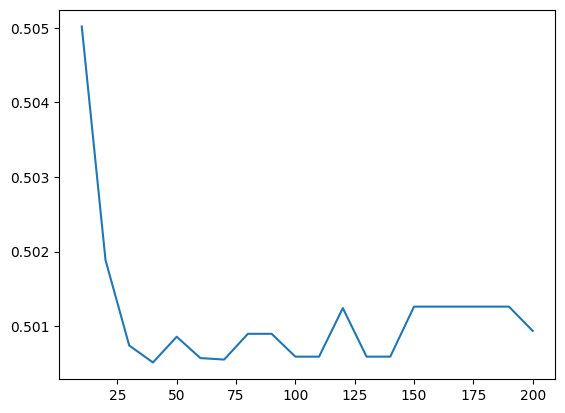

In [318]:
plt.plot(df_scores.n_estimators, df_scores.auc)

We can try with different depths:

In [322]:
scores = []

for d in [5, 10, 15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train, y_clients_train)

        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_clients_val, y_pred)
        scores.append((d, n, auc))

In [325]:
df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "auc"])
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.5
1,5,20,0.5
2,5,30,0.5
3,5,40,0.5
4,5,50,0.5


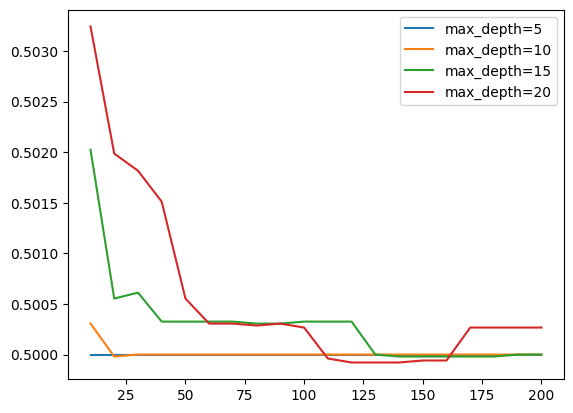

In [326]:
for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d'% d)
plt.legend()

In [327]:
df_scores[df_scores.max_depth == 20]

,max_depth,n_estimators,auc
60,20,10,0.503241
61,20,20,0.501985
62,20,30,0.501816
63,20,40,0.501510
64,20,50,0.500553
65,20,60,0.500306
66,20,70,0.500306
67,20,80,0.500286
68,20,90,0.500306
69,20,100,0.500267


The best parameters seem to be:
- n_estimators: 10
- max_depth: 20

In [328]:
max_depth = 20

Finally I will try with diferent min_samples_leaf:

In [330]:
scores = []

for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=42)
        rf.fit(X_train, y_clients_train)

        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_clients_val, y_pred)
        scores.append((s, n, auc))

In [331]:
df_scores = pd.DataFrame(scores, columns=["min_samples_leaf", "n_estimators", "auc"])
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.503241
1,1,20,0.501985
2,1,30,0.501816
3,1,40,0.501510
4,1,50,0.500553


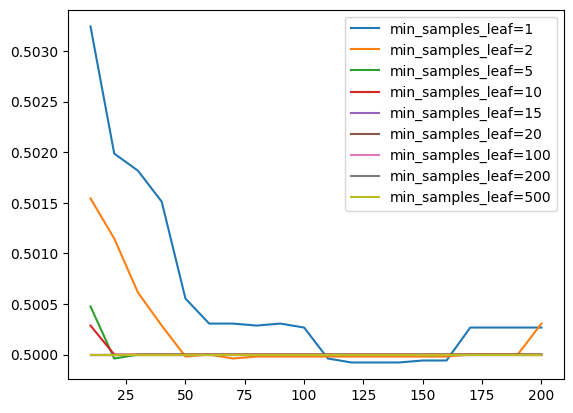

In [333]:
for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_samples_leaf=%d'% s)
plt.legend()

The best result I got was using:
- n_estimators: 10
- max_depth: 20
- min_sample_leaf: 1

With a auc score of 0.503


The `Decision Tree Classifier` seams to be the best model using `max_depth = 20` and `min_samples_leaf = 5`.

# Train Script

In [349]:
# Feature lists
category_cols = ['client_catg', 'region', 'district']
numeric_cols = ['age_months', 'consumption_level_1_mean',
    'consumption_level_1_std', 'consumption_level_1_min',
    'consumption_level_1_max', 'consumption_level_2_mean',
    'consumption_level_2_std', 'consumption_level_2_min',
    'consumption_level_2_max', 'consumption_level_3_mean',
    'consumption_level_3_std', 'consumption_level_3_min',
    'consumption_level_3_max', 'consumption_level_4_mean',
    'consumption_level_4_std', 'consumption_level_4_min',
    'consumption_level_4_max', 'total_consumption_mean',
    'total_consumption_std', 'total_consumption_min',
    'total_consumption_max']

# Model parameters
max_depth=20
min_samples_leaf=5

# Load data
df_clients = pd.concat([pd.read_csv('data/client_train.csv')])
df_invoices = pd.concat([pd.read_csv('data/invoice_train.csv')])

# Editing clients dataset
df_clients['district'] = df_clients['disrict']
del df_clients['disrict']
df_clients.creation_date = pd.to_datetime(df_clients.creation_date, dayfirst=True)
df_clients['client_id'] = df_clients['client_id'].str.lower()
df_clients['district'] = 'district_' + df_clients['district'].astype('str')
df_clients['region'] = 'region_' + df_clients['region'].astype('str')
df_clients['client_catg'] = 'client_catg_' + df_clients['client_catg'].astype('str')
df_clients['target'] = df_clients['target'].astype(int)

# Editing invoices dataset
df_invoices['client_id'] = df_invoices['client_id'].str.lower()
df_invoices['counter_type'] = df_invoices['counter_type'].str.lower()
df_invoices['counter_status'] = df_invoices['counter_statue']
df_invoices['consumption_level_1'] = df_invoices['consommation_level_1']
df_invoices['consumption_level_2'] = df_invoices['consommation_level_2']
df_invoices['consumption_level_3'] = df_invoices['consommation_level_3']
df_invoices['consumption_level_4'] = df_invoices['consommation_level_4']
del df_invoices['counter_statue']
del df_invoices['consommation_level_1']
del df_invoices['consommation_level_2']
del df_invoices['consommation_level_3']
del df_invoices['consommation_level_4']
df_invoices.counter_status = pd.to_numeric(df_invoices.counter_status, errors='coerce').fillna(999999).astype(int)
df_invoices = df_invoices[df_invoices.counter_status <= 5]
df_invoices['counter_status'] = 'counter_status_' + df_invoices['counter_status'].astype(str)
df_invoices.invoice_date = pd.to_datetime(df_invoices.invoice_date, yearfirst=True)

# Extending dataset
max_date = df_invoices.invoice_date.max()
df_clients_extended = df_clients.copy()
df_invoices_extended = df_invoices.copy()
df_invoices_extended = df_invoices_extended.merge(df_clients[['client_id', 'target']], on='client_id', how='left')
df_clients_extended['age_months'] = (max_date.year - df_clients_extended['creation_date'].dt.year) * 12 + (max_date.month-  df_clients_extended['creation_date'].dt.month)
df_invoices_extended['total_consumption'] = (df_invoices_extended['consumption_level_1'] + df_invoices_extended['consumption_level_2'] + df_invoices_extended['consumption_level_3'] + df_invoices_extended['consumption_level_4'])
consumption_cols = ['consumption_level_1', 'consumption_level_2', 'consumption_level_3', 'consumption_level_4', 'total_consumption']
for c in consumption_cols:
    df_agg = df_invoices_extended.groupby('client_id')[c].agg(['mean', 'std', 'min', 'max']).reset_index()
    df_agg.rename(columns={'mean': f'{c}_mean', 'std': f'{c}_std', 'min': f'{c}_min', 'max': f'{c}_max'}, inplace=True)
    df_clients_extended = df_clients_extended.merge(df_agg, on='client_id', how='left')
df_clients_extended = df_clients_extended.fillna(0)

# Spliting dataset
df_clients_full_train, df_clients_test = train_test_split(df_clients_extended, test_size=0.2, random_state=42)
df_clients_full_train.reset_index(drop=True)
df_clients_test.reset_index(drop=True)
y_clients_full_train = df_clients_full_train.target
y_clients_test = df_clients_test.target
del df_clients_full_train['target']
del df_clients_test['target']

# Training model
dicts = df_clients_full_train[category_cols + numeric_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
dt.fit(X_train, y_clients_full_train)

/var/folders/km/dql4gckx6ps4lrl0mdrhnsbh0000gn/T/ipykernel_2856/1240024305.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_invoices = pd.concat([pd.read_csv('data/invoice_train.csv')])


auc: 0.5253350423695073


# Calling the service

In [369]:
df_clients_test[df_clients_test.client_id == 'train_client_8616'].to_dict()

{'client_id': {120117: 'train_client_8616'},
 'client_catg': {120117: 'client_catg_11'},
 'region': {120117: 'region_103'},
 'creation_date': {120117: Timestamp('2003-08-12 00:00:00')},
 'district': {120117: 'district_69'},
 'age_months': {120117: 196},
 'consumption_level_1_mean': {120117: 934.4594594594595},
 'consumption_level_1_std': {120117: 302.84719236262026},
 'consumption_level_1_min': {120117: 165.0},
 'consumption_level_1_max': {120117: 2090.0},
 'consumption_level_2_mean': {120117: 79.97297297297297},
 'consumption_level_2_std': {120117: 125.50375967951595},
 'consumption_level_2_min': {120117: 0.0},
 'consumption_level_2_max': {120117: 400.0},
 'consumption_level_3_mean': {120117: 12.783783783783784},
 'consumption_level_3_std': {120117: 77.760720995434},
 'consumption_level_3_min': {120117: 0.0},
 'consumption_level_3_max': {120117: 473.0},
 'consumption_level_4_mean': {120117: 0.0},
 'consumption_level_4_std': {120117: 0.0},
 'consumption_level_4_min': {120117: 0.0},
 'c

## Local

In [397]:
import requests

url = "http://0.0.0.0:9696/predict"
client = {
 'client_catg':  'client_catg_11',
 'region': 'region_103',
 'district': 'district_69',
 'age_months': 196,
 'consumption_level_1_mean': 934.4594594594595,
 'consumption_level_1_std': 302.84719236262026,
 'consumption_level_1_min': 165.0,
 'consumption_level_1_max': 2090.0,
 'consumption_level_2_mean': 79.97297297297297,
 'consumption_level_2_std': 125.50375967951595,
 'consumption_level_2_max': 400.0
}
requests.post(url, json=client).json()

{'prediction': 1.0, 'probability': 0.6}

## Deployed

In [403]:
import requests

url = "http://fraud-service-dev.eba-enrjx8jr.us-east-1.elasticbeanstalk.com/predict"
client = {
 'client_catg':  'client_catg_11',
 'region': 'region_103',
 'district': 'district_69',
 'age_months': 196,
 'consumption_level_1_mean': 934.4594594594595,
 'consumption_level_1_std': 302.84719236262026,
 'consumption_level_1_min': 165.0,
 'consumption_level_1_max': 2090.0,
 'consumption_level_2_mean': 79.97297297297297,
 'consumption_level_2_std': 125.50375967951595,
 'consumption_level_2_max': 400.0
}
requests.post(url, json=client).json()

{'prediction': 1.0, 'probability': 0.6}